In [29]:
import sys
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, matthews_corrcoef, f1_score

from sklearn.svm import SVC

sys.path.append("../../")

from helpers.split import tag_label_feature_split
from helpers.assess import make_classification_report, make_confusion_matrix

DATASET_FOLDER = "../../datasets/"

In [2]:
# read a data set
dataset="dataset_00_all.pickle"
df = pd.read_pickle(DATASET_FOLDER + dataset)

In [3]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
# we are going to validate using k-fold cross validation so we will not
# create a separate validation set here

# split into train/validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1962
)

In [5]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Baseline A Default SVC Classifier**

In [6]:
classifier = SVC(class_weight='balanced', random_state=1962)

In [7]:
scoring = ['matthews_corrcoef', 'f1_macro', 'balanced_accuracy']

In [8]:
scores = cross_validate (classifier, 
                         X_train_scaled, 
                         y=y_train, 
                         scoring=scoring, 
                         return_train_score=True, 
                         return_estimator=True,
                         n_jobs=-1)

In [9]:
scores

{'fit_time': array([485.37560773, 486.58632159, 485.57206368, 486.34850979,
        488.43695354]),
 'score_time': array([113.92202759, 115.24112821, 111.67763042, 114.13551927,
        111.67986703]),
 'estimator': [SVC(class_weight='balanced', random_state=1962),
  SVC(class_weight='balanced', random_state=1962),
  SVC(class_weight='balanced', random_state=1962),
  SVC(class_weight='balanced', random_state=1962),
  SVC(class_weight='balanced', random_state=1962)],
 'test_matthews_corrcoef': array([0.62210034, 0.6132632 , 0.62760916, 0.60977519, 0.62515211]),
 'train_matthews_corrcoef': array([0.76379666, 0.75849296, 0.76189183, 0.75826136, 0.76077731]),
 'test_f1_macro': array([0.60684832, 0.60074932, 0.61863507, 0.59813889, 0.61117679]),
 'train_f1_macro': array([0.79237095, 0.78491733, 0.78495973, 0.78266746, 0.78897893]),
 'test_balanced_accuracy': array([0.65069484, 0.65629939, 0.66904366, 0.64138003, 0.65898045]),
 'train_balanced_accuracy': array([0.88212305, 0.87604119, 0.8784

In [10]:
# mean validation mcc
scores['test_matthews_corrcoef'].mean()

0.6195799990821136

In [11]:
# mean validation macro average f1
scores['test_f1_macro'].mean()

0.6071096772126381

In [12]:
# mean validation balanced accuracy
scores['test_balanced_accuracy'].mean()

0.6552796736976686

In [16]:
test_mcc = []
test_f1 = []
test_balanced_accuracy = []

for classifier in scores['estimator']:
    predictions = classifier.predict(X_test_scaled)
    test_mcc.append (matthews_corrcoef (y_test, predictions))
    test_f1.append  (f1_score (y_test, predictions, average='macro'))
    test_balanced_accuracy.append (balanced_accuracy_score(y_test, predictions))

In [19]:
# mean test mcc
np.mean(test_mcc)

0.612579456874313

In [20]:
# mean test macro average f1
np.mean(test_f1)

0.5909841546323944

In [22]:
# mean test balanced_accuracy
np.mean(test_balanced_accuracy)

0.6282944627005651

**Tune with GridSearchCV**

In [7]:
#param_grid = [
#  {'C': [1, 10, 100, 1000],
#   'gamma': [0.001, 0.0001],
#   'kernel': ['rbf'],
#   'class_weight': ['balanced'],
#   'random_state': [1962]
#  }]

#tuned_classifier = GridSearchCV(SVC(), param_grid, scoring='matthews_corrcoef', n_jobs=-1, verbose=2)
#tuned_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf'],
                          'random_state': [1962]}],
             scoring='matthews_corrcoef', verbose=2)

In [9]:
# tuned_classifier.best_params_

{'C': 1,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 1962}

Gridsearch returns the following parameters: C=1, gamma=.001

In [16]:
classifier = SVC(C=1, gamma=.001, class_weight='balanced', random_state=1962)

In [17]:
scoring = ['matthews_corrcoef', 'f1_macro', 'balanced_accuracy']

In [18]:
scores = cross_validate (classifier, 
                         X_train_scaled, 
                         y=y_train, 
                         scoring=scoring, 
                         return_train_score=True, 
                         return_estimator=True,
                         n_jobs=-1)

In [19]:
scores

{'fit_time': array([596.98870134, 610.71513915, 611.92576265, 609.24402285,
        607.10533142]),
 'score_time': array([124.12618852, 119.90413523, 122.37794924, 121.14912724,
        120.03349113]),
 'estimator': [SVC(C=1, class_weight='balanced', gamma=0.001, random_state=1962),
  SVC(C=1, class_weight='balanced', gamma=0.001, random_state=1962),
  SVC(C=1, class_weight='balanced', gamma=0.001, random_state=1962),
  SVC(C=1, class_weight='balanced', gamma=0.001, random_state=1962),
  SVC(C=1, class_weight='balanced', gamma=0.001, random_state=1962)],
 'test_matthews_corrcoef': array([0.62021973, 0.61327649, 0.62453416, 0.61324149, 0.61971345]),
 'train_matthews_corrcoef': array([0.86207819, 0.86485565, 0.86526114, 0.86335539, 0.86089657]),
 'test_f1_macro': array([0.60825135, 0.60825301, 0.6248987 , 0.61564637, 0.60942338]),
 'train_f1_macro': array([0.91702926, 0.91789949, 0.917288  , 0.91793372, 0.91624992]),
 'test_balanced_accuracy': array([0.57741652, 0.58745975, 0.60857723, 0

In [20]:
# mean validation mcc
scores['test_matthews_corrcoef'].mean()

0.6181970627698371

In [21]:
# mean validation macro average f1
scores['test_f1_macro'].mean()

0.6132945639363367

In [22]:
# mean validation balanced accuracy
scores['test_balanced_accuracy'].mean()

0.5912565551627226

In [23]:
test_mcc = []
test_f1 = []
test_balanced_accuracy = []

for classifier in scores['estimator']:
    predictions = classifier.predict(X_test_scaled)
    test_mcc.append (matthews_corrcoef (y_test, predictions))
    test_f1.append  (f1_score (y_test, predictions, average='macro'))
    test_balanced_accuracy.append (balanced_accuracy_score(y_test, predictions))

In [24]:
# mean test mcc
np.mean(test_mcc)

0.6142906099056941

In [25]:
# mean test macro average f1
np.mean(test_f1)

0.6019575448701864

In [26]:
# mean test balanced_accuracy
np.mean(test_balanced_accuracy)

0.570387848020068

**With PCA**

In [31]:
# PCA
pca = PCA(n_components=.95, random_state=1962)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [32]:
pca_classifier = SVC(class_weight='balanced', random_state=1962)

In [33]:
pca_scores = cross_validate (pca_classifier, 
                             X_train_pca, 
                             y=y_train, 
                             scoring=scoring, 
                             return_train_score=True, 
                             return_estimator=True,
                             n_jobs=-1)

In [34]:
pca_scores

{'fit_time': array([67.23929691, 66.64424992, 65.62238407, 64.46132135, 65.96628594]),
 'score_time': array([16.6308229 , 17.09125829, 17.19252944, 17.51693249, 17.09016395]),
 'estimator': [SVC(class_weight='balanced', random_state=1962),
  SVC(class_weight='balanced', random_state=1962),
  SVC(class_weight='balanced', random_state=1962),
  SVC(class_weight='balanced', random_state=1962),
  SVC(class_weight='balanced', random_state=1962)],
 'test_matthews_corrcoef': array([0.61235209, 0.60322687, 0.61322497, 0.59931858, 0.60987083]),
 'train_matthews_corrcoef': array([0.74429808, 0.73962919, 0.7425356 , 0.73998713, 0.7411266 ]),
 'test_f1_macro': array([0.59406234, 0.58834435, 0.60144639, 0.58784867, 0.59106105]),
 'train_f1_macro': array([0.76442315, 0.75908255, 0.75889353, 0.75706376, 0.76280042]),
 'test_balanced_accuracy': array([0.64882804, 0.65649146, 0.65957054, 0.64488384, 0.64845717]),
 'train_balanced_accuracy': array([0.86750183, 0.86109266, 0.86472065, 0.86395086, 0.868099

In [35]:
# mean validation mcc
pca_scores['test_matthews_corrcoef'].mean()

0.6075986654116791

In [36]:
# mean validation macro average f1
pca_scores['test_f1_macro'].mean()

0.5925525607892862

In [37]:
# mean validation balanced accuracy
pca_scores['test_balanced_accuracy'].mean()

0.6516462127286342

In [38]:
pca_test_mcc = []
pca_test_f1 = []
pca_test_balanced_accuracy = []

for classifier in pca_scores['estimator']:
    predictions = classifier.predict(X_test_pca)
    pca_test_mcc.append (matthews_corrcoef (y_test, predictions))
    pca_test_f1.append  (f1_score (y_test, predictions, average='macro'))
    pca_test_balanced_accuracy.append (balanced_accuracy_score(y_test, predictions))

In [39]:
# mean test mcc
np.mean(pca_test_mcc)

0.6009077945896152

In [40]:
# mean test macro average f1
np.mean(pca_test_f1)

0.5766216806046616

In [41]:
# mean test balanced_accuracy
np.mean(pca_test_balanced_accuracy)

0.6241114001567204

In [70]:
# get the classifier from the group with the highest mcc
idx=np.argmax(pca_scores['test_matthews_corrcoef'])
best_classifier = pca_scores['estimator'][idx]
best_classifier_predictions = best_classifier.predict(X_test_pca)

In [71]:
make_classification_report(y_test, best_classifier_predictions, label_encoder=le, print_report=True)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.25    0.46      0.32       94  0.32
  genre_classical       0.84    0.88      0.86     1055  0.82
    genre_country       0.36    0.56      0.44       82  0.44
      genre_disco       0.36    0.49      0.41       72  0.41
     genre_hiphop       0.63    0.81      0.71      425  0.68
       genre_jazz       0.57    0.66      0.61      311  0.58
      genre_metal       0.55    0.72      0.63      166  0.62
        genre_pop       0.67    0.49      0.57     1069  0.46
     genre_reggae       0.58    0.62      0.60      197  0.58
       genre_rock       0.73    0.58      0.64      800  0.58
                                                             
         accuracy                         0.67     4271  0.60
        macro avg       0.55    0.63      0.58     4271      
     weighted avg       0.68    0.67      0.67     4271      
        

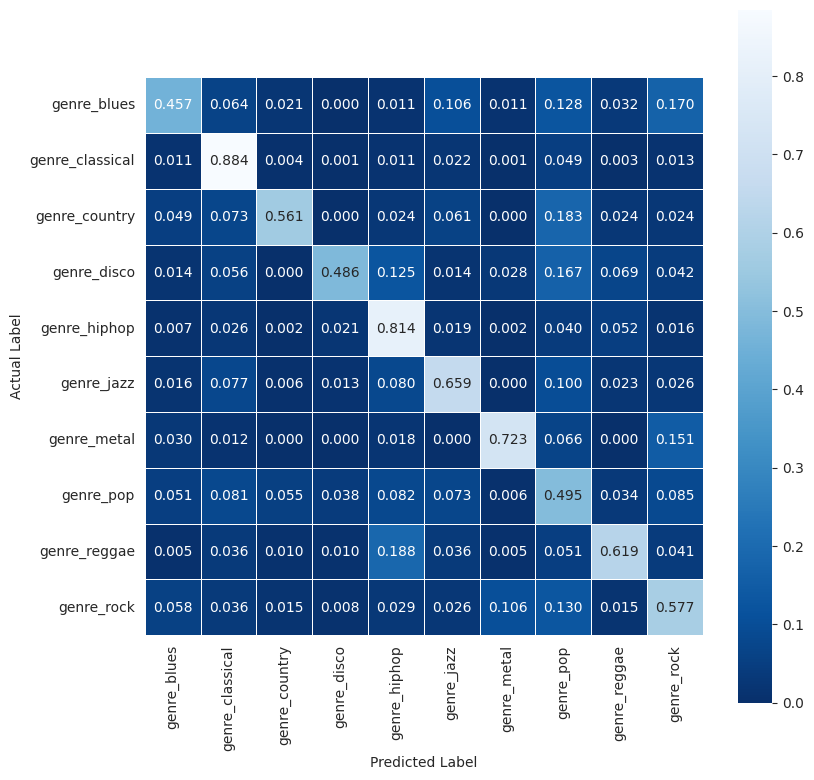

In [72]:
make_confusion_matrix(y_test, best_classifier_predictions, label_encoder=le)
pass

**Tune with GridSearchCV**

In [43]:
#param_grid = [
#  {'C': [1, 10, 100, 1000],
#   'gamma': [0.001, 0.0001],
#   'kernel': ['rbf'],
#   'class_weight': ['balanced'],
#   'random_state': [1962]
#  }]

#pca_tuned_classifier = GridSearchCV(SVC(), param_grid, scoring='matthews_corrcoef', n_jobs=-1, verbose=2)
#pca_tuned_classifier.fit(X_train_pca, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf'],
                          'random_state': [1962]}],
             scoring='matthews_corrcoef', verbose=2)

In [44]:
#pca_tuned_classifier.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 1962}

Gridsearch returns the following parameters: C=100, gamma=.001

In [45]:
classifier = SVC(C=100, gamma=.001, class_weight='balanced', random_state=1962)

In [46]:
scoring = ['matthews_corrcoef', 'f1_macro', 'balanced_accuracy']

In [47]:
scores = cross_validate (classifier, 
                         X_train_pca, 
                         y=y_train, 
                         scoring=scoring, 
                         return_train_score=True, 
                         return_estimator=True,
                         n_jobs=-1)

In [48]:
scores

{'fit_time': array([95.98718619, 88.22617769, 92.24650979, 93.78170395, 87.59519315]),
 'score_time': array([18.53276825, 18.51030111, 18.27694702, 18.35994387, 18.50695419]),
 'estimator': [SVC(C=100, class_weight='balanced', gamma=0.001, random_state=1962),
  SVC(C=100, class_weight='balanced', gamma=0.001, random_state=1962),
  SVC(C=100, class_weight='balanced', gamma=0.001, random_state=1962),
  SVC(C=100, class_weight='balanced', gamma=0.001, random_state=1962),
  SVC(C=100, class_weight='balanced', gamma=0.001, random_state=1962)],
 'test_matthews_corrcoef': array([0.6548675 , 0.65325984, 0.65470321, 0.6553099 , 0.65511046]),
 'train_matthews_corrcoef': array([0.9995545 , 0.99910912, 0.99937636, 0.99937634, 0.99946544]),
 'test_f1_macro': array([0.631822  , 0.6337389 , 0.63796044, 0.6246024 , 0.62859868]),
 'train_f1_macro': array([0.99975218, 0.99912668, 0.99935951, 0.99938508, 0.99970545]),
 'test_balanced_accuracy': array([0.57170386, 0.58189295, 0.58440168, 0.57131836, 0.580

In [49]:
# mean validation mcc
scores['test_matthews_corrcoef'].mean()

0.6546501802119791

In [50]:
# mean validation macro average f1
scores['test_f1_macro'].mean()

0.6313444852998605

In [51]:
# mean validation balanced accuracy
scores['test_balanced_accuracy'].mean()

0.5779450743092973

In [52]:
test_mcc = []
test_f1 = []
test_balanced_accuracy = []

for classifier in scores['estimator']:
    predictions = classifier.predict(X_test_pca)
    test_mcc.append (matthews_corrcoef (y_test, predictions))
    test_f1.append  (f1_score (y_test, predictions, average='macro'))
    test_balanced_accuracy.append (balanced_accuracy_score(y_test, predictions))

In [53]:
# mean test mcc
np.mean(test_mcc)

0.6573261031089146

In [54]:
# mean test macro average f1
np.mean(test_f1)

0.6249384461361914

In [55]:
# mean test balanced_accuracy
np.mean(test_balanced_accuracy)

0.5632563379340205

In [66]:
# get the classifier from the group with the highest mcc
idx=np.argmax(scores['test_matthews_corrcoef'])
best_classifier = scores['estimator'][idx]
best_classifier_predictions = best_classifier.predict(X_test_pca)

In [67]:
make_classification_report(y_test, best_classifier_predictions, label_encoder=le, print_report=True)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.74    0.21      0.33       94  0.39
  genre_classical       0.80    0.92      0.86     1055  0.81
    genre_country       0.81    0.37      0.50       82  0.54
      genre_disco       0.82    0.38      0.51       72  0.55
     genre_hiphop       0.72    0.71      0.72      425  0.69
       genre_jazz       0.77    0.54      0.63      311  0.62
      genre_metal       0.91    0.55      0.69      166  0.70
        genre_pop       0.61    0.75      0.67     1069  0.55
     genre_reggae       0.77    0.50      0.61      197  0.61
       genre_rock       0.74    0.73      0.73      800  0.67
                                                             
         accuracy                         0.72     4271  0.66
        macro avg       0.77    0.57      0.63     4271      
     weighted avg       0.73    0.72      0.71     4271      
        

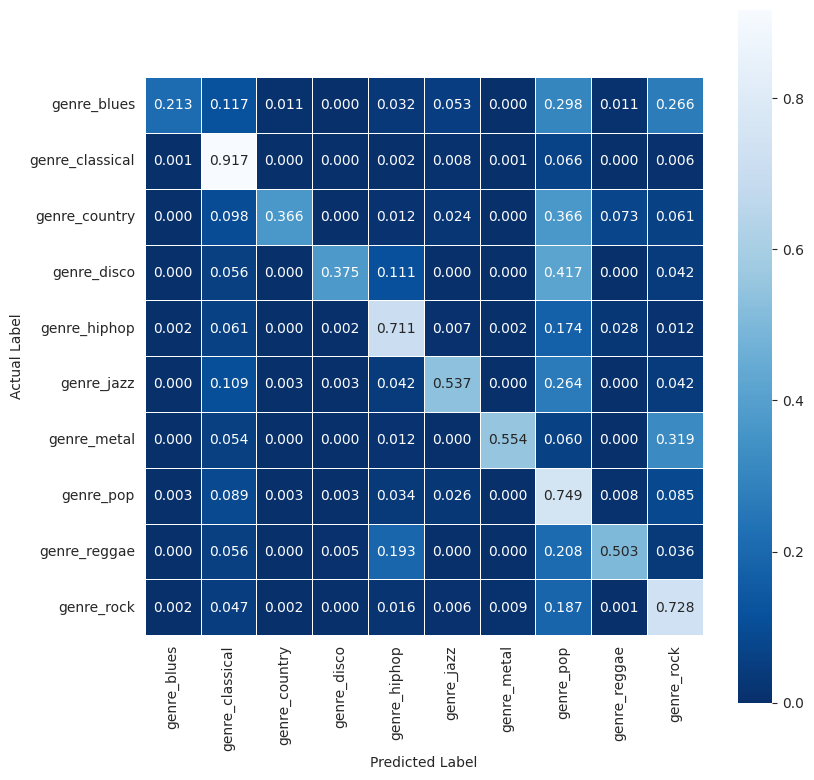

In [69]:
make_confusion_matrix(y_test, best_classifier_predictions, label_encoder=le)
pass